In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.metrics import (accuracy_score as sk_accuracy,
                            precision_score as sk_precision,
                            recall_score as sk_recall,
                            f1_score as sk_f1,
                            roc_auc_score as sk_roc_auc,
                            average_precision_score as sk_pr_auc,
                            precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from scipy.integrate import trapezoid
import optuna
from optuna.logging import set_verbosity

In [108]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# EDA

In [109]:
print(train_data.shape)
print(test_data.shape)

(15000, 24)
(10000, 23)


In [110]:
none_count = train_data['smoking'].isnull().sum()
print(f"Количество None значений в smoking: {none_count}")

Количество None значений в smoking: 0


Пустые значения целевой переменной отсутствуют

In [111]:
missing_data = train_data.isnull().sum()
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100

missing_data_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})

print(missing_data_summary)

                     Missing Count  Missing Percentage
id                               0                 0.0
age                              0                 0.0
height(cm)                       0                 0.0
weight(kg)                       0                 0.0
waist(cm)                        0                 0.0
eyesight(left)                   0                 0.0
eyesight(right)                  0                 0.0
hearing(left)                    0                 0.0
hearing(right)                   0                 0.0
systolic                         0                 0.0
relaxation                       0                 0.0
fasting blood sugar              0                 0.0
Cholesterol                      0                 0.0
triglyceride                     0                 0.0
HDL                              0                 0.0
LDL                              0                 0.0
hemoglobin                       0                 0.0
Urine prot

Пустых значений нет

Разобьём признаки по категориям.

In [112]:
numerical_features = train_data.drop(columns='smoking').select_dtypes(include=np.number).columns
categorical_features = train_data.drop(columns='smoking').select_dtypes(exclude=np.number).columns

print("Числовые признаки:")
print(numerical_features)
print("\nКатегориальные признаки:")
print(categorical_features)

Числовые признаки:
Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')

Категориальные признаки:
Index([], dtype='object')


Все признаки являются числовыми или порядковыми.

Выбросов целевой переменной нет. Она принимает только 2 значения.

Столбец id не даёт нам никакой информации, удалим его.

In [113]:
train_data = train_data.drop('id', axis=1)

# Матрица корреляции

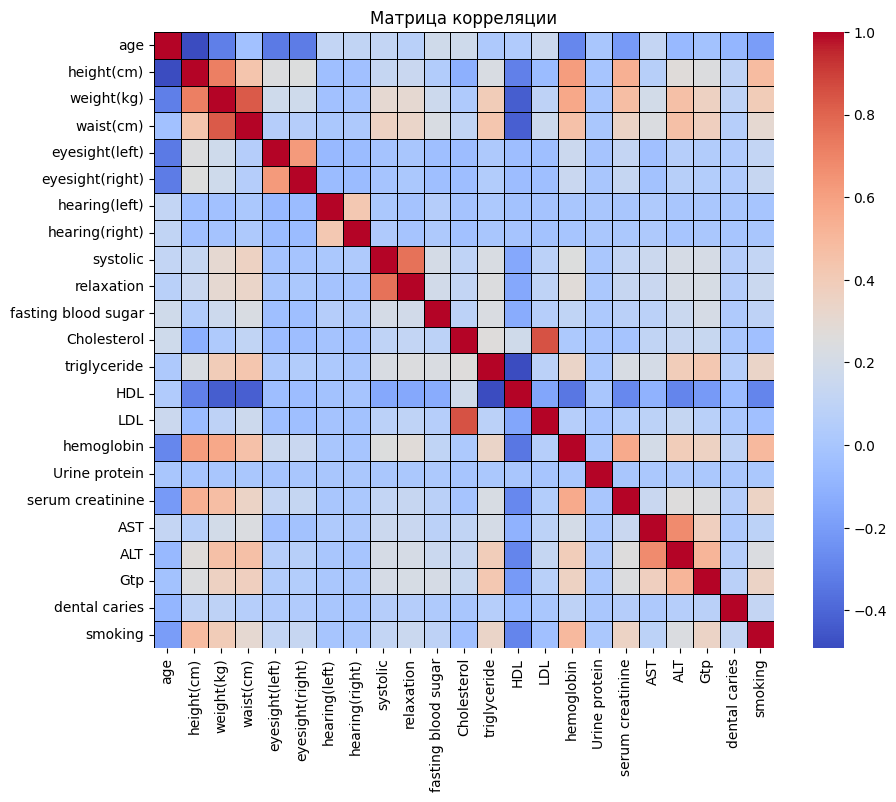

In [114]:
correlation_matrix = train_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Матрица корреляции')
plt.show()

In [115]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]
num_high_corr = len(high_corr_features)

print(f"Количество признаков с корреляцией > 0.9: {num_high_corr}")

Количество признаков с корреляцией > 0.9: 0


# Графики

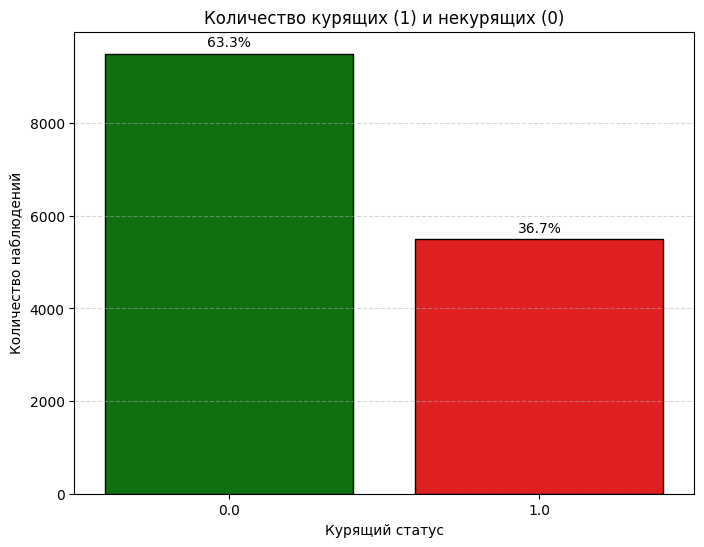

In [116]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=train_data,
    x="smoking",
    hue="smoking",
    palette=["green", "red"],
    edgecolor="black",
    legend=False
)

total = len(train_data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01*total,
            f'{height/total:.1%}',
            ha="center")

plt.title("Количество курящих (1) и некурящих (0)")
plt.xlabel("Курящий статус")
plt.ylabel("Количество наблюдений")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

Распределение курящих и некурящик по признаками.

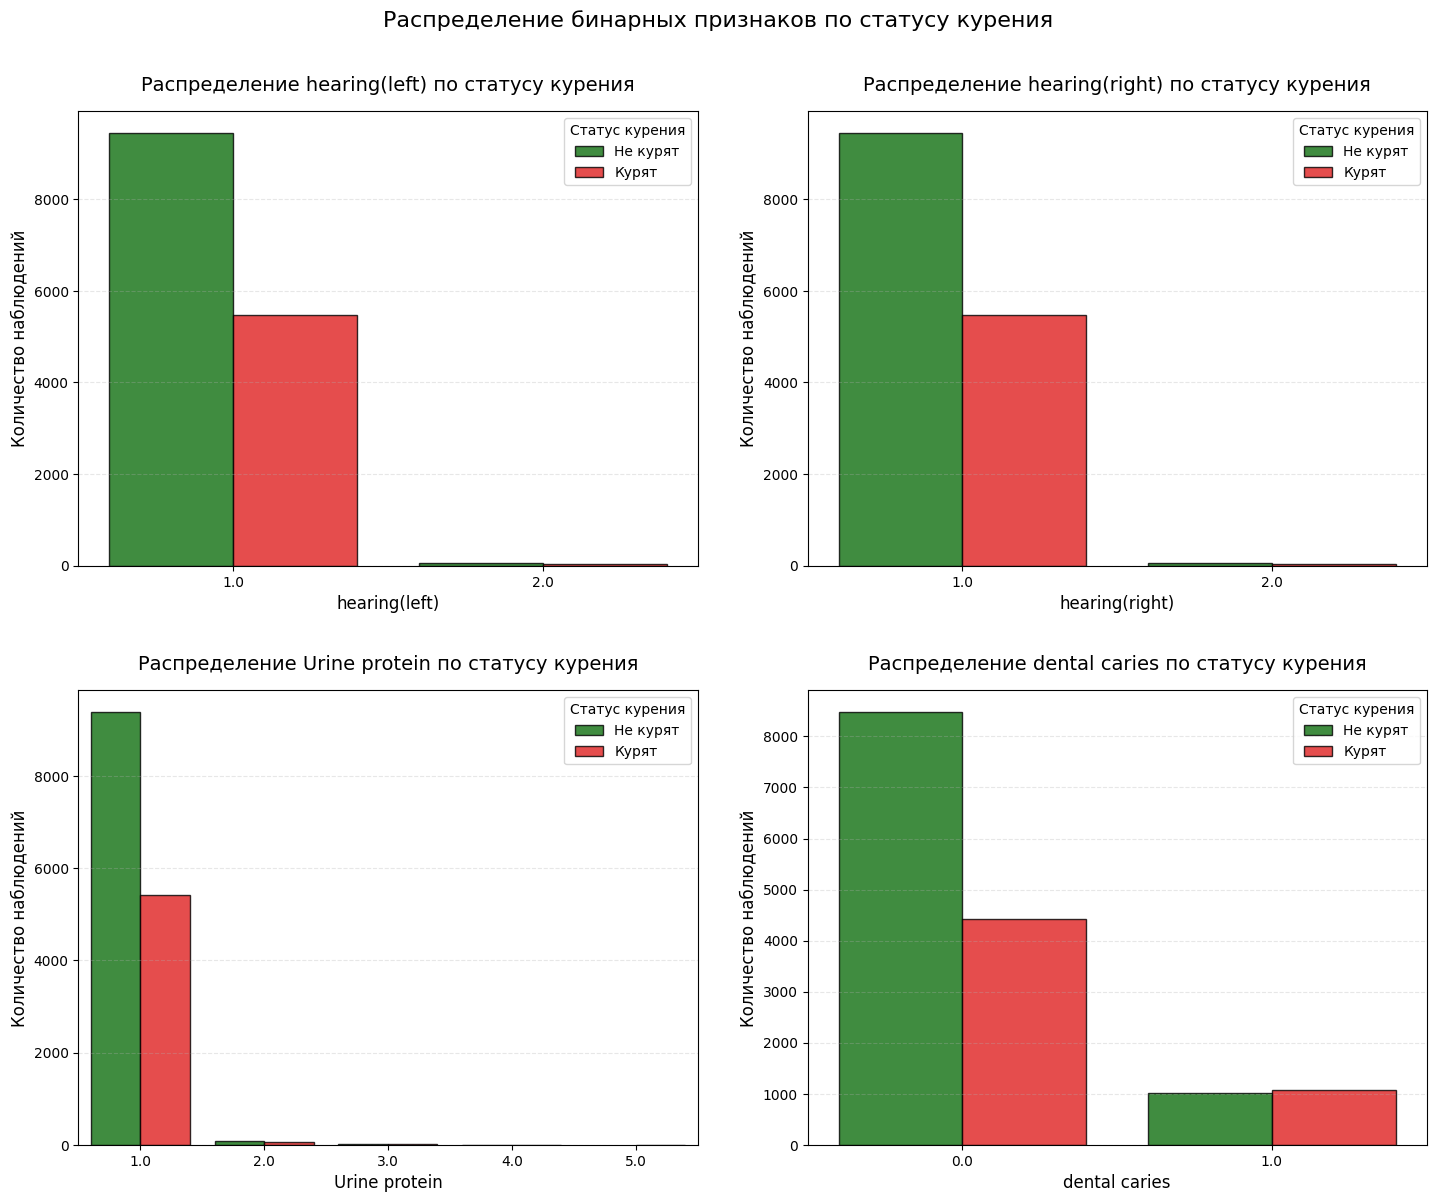

In [117]:
binary_features = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']

n_cats = len(binary_features)
rows = int(np.ceil(n_cats / 2))
plt.figure(figsize=(15, rows * 6))

palette = ["green", "red"]

for i, feature in enumerate(binary_features, 1):
    plt.subplot(rows, 2, i)

    ax = sns.countplot(
        x=feature,
        hue='smoking',
        data=train_data,
        palette=palette,
        edgecolor='black',
        alpha=0.8
    )

    plt.title(f'Распределение {feature} по статусу курения', fontsize=14, pad=15)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(['Не курят', 'Курят'], title='Статус курения', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout(pad=3.0)
plt.suptitle('Распределение бинарных признаков по статусу курения', y=1.02, fontsize=16)
plt.show()

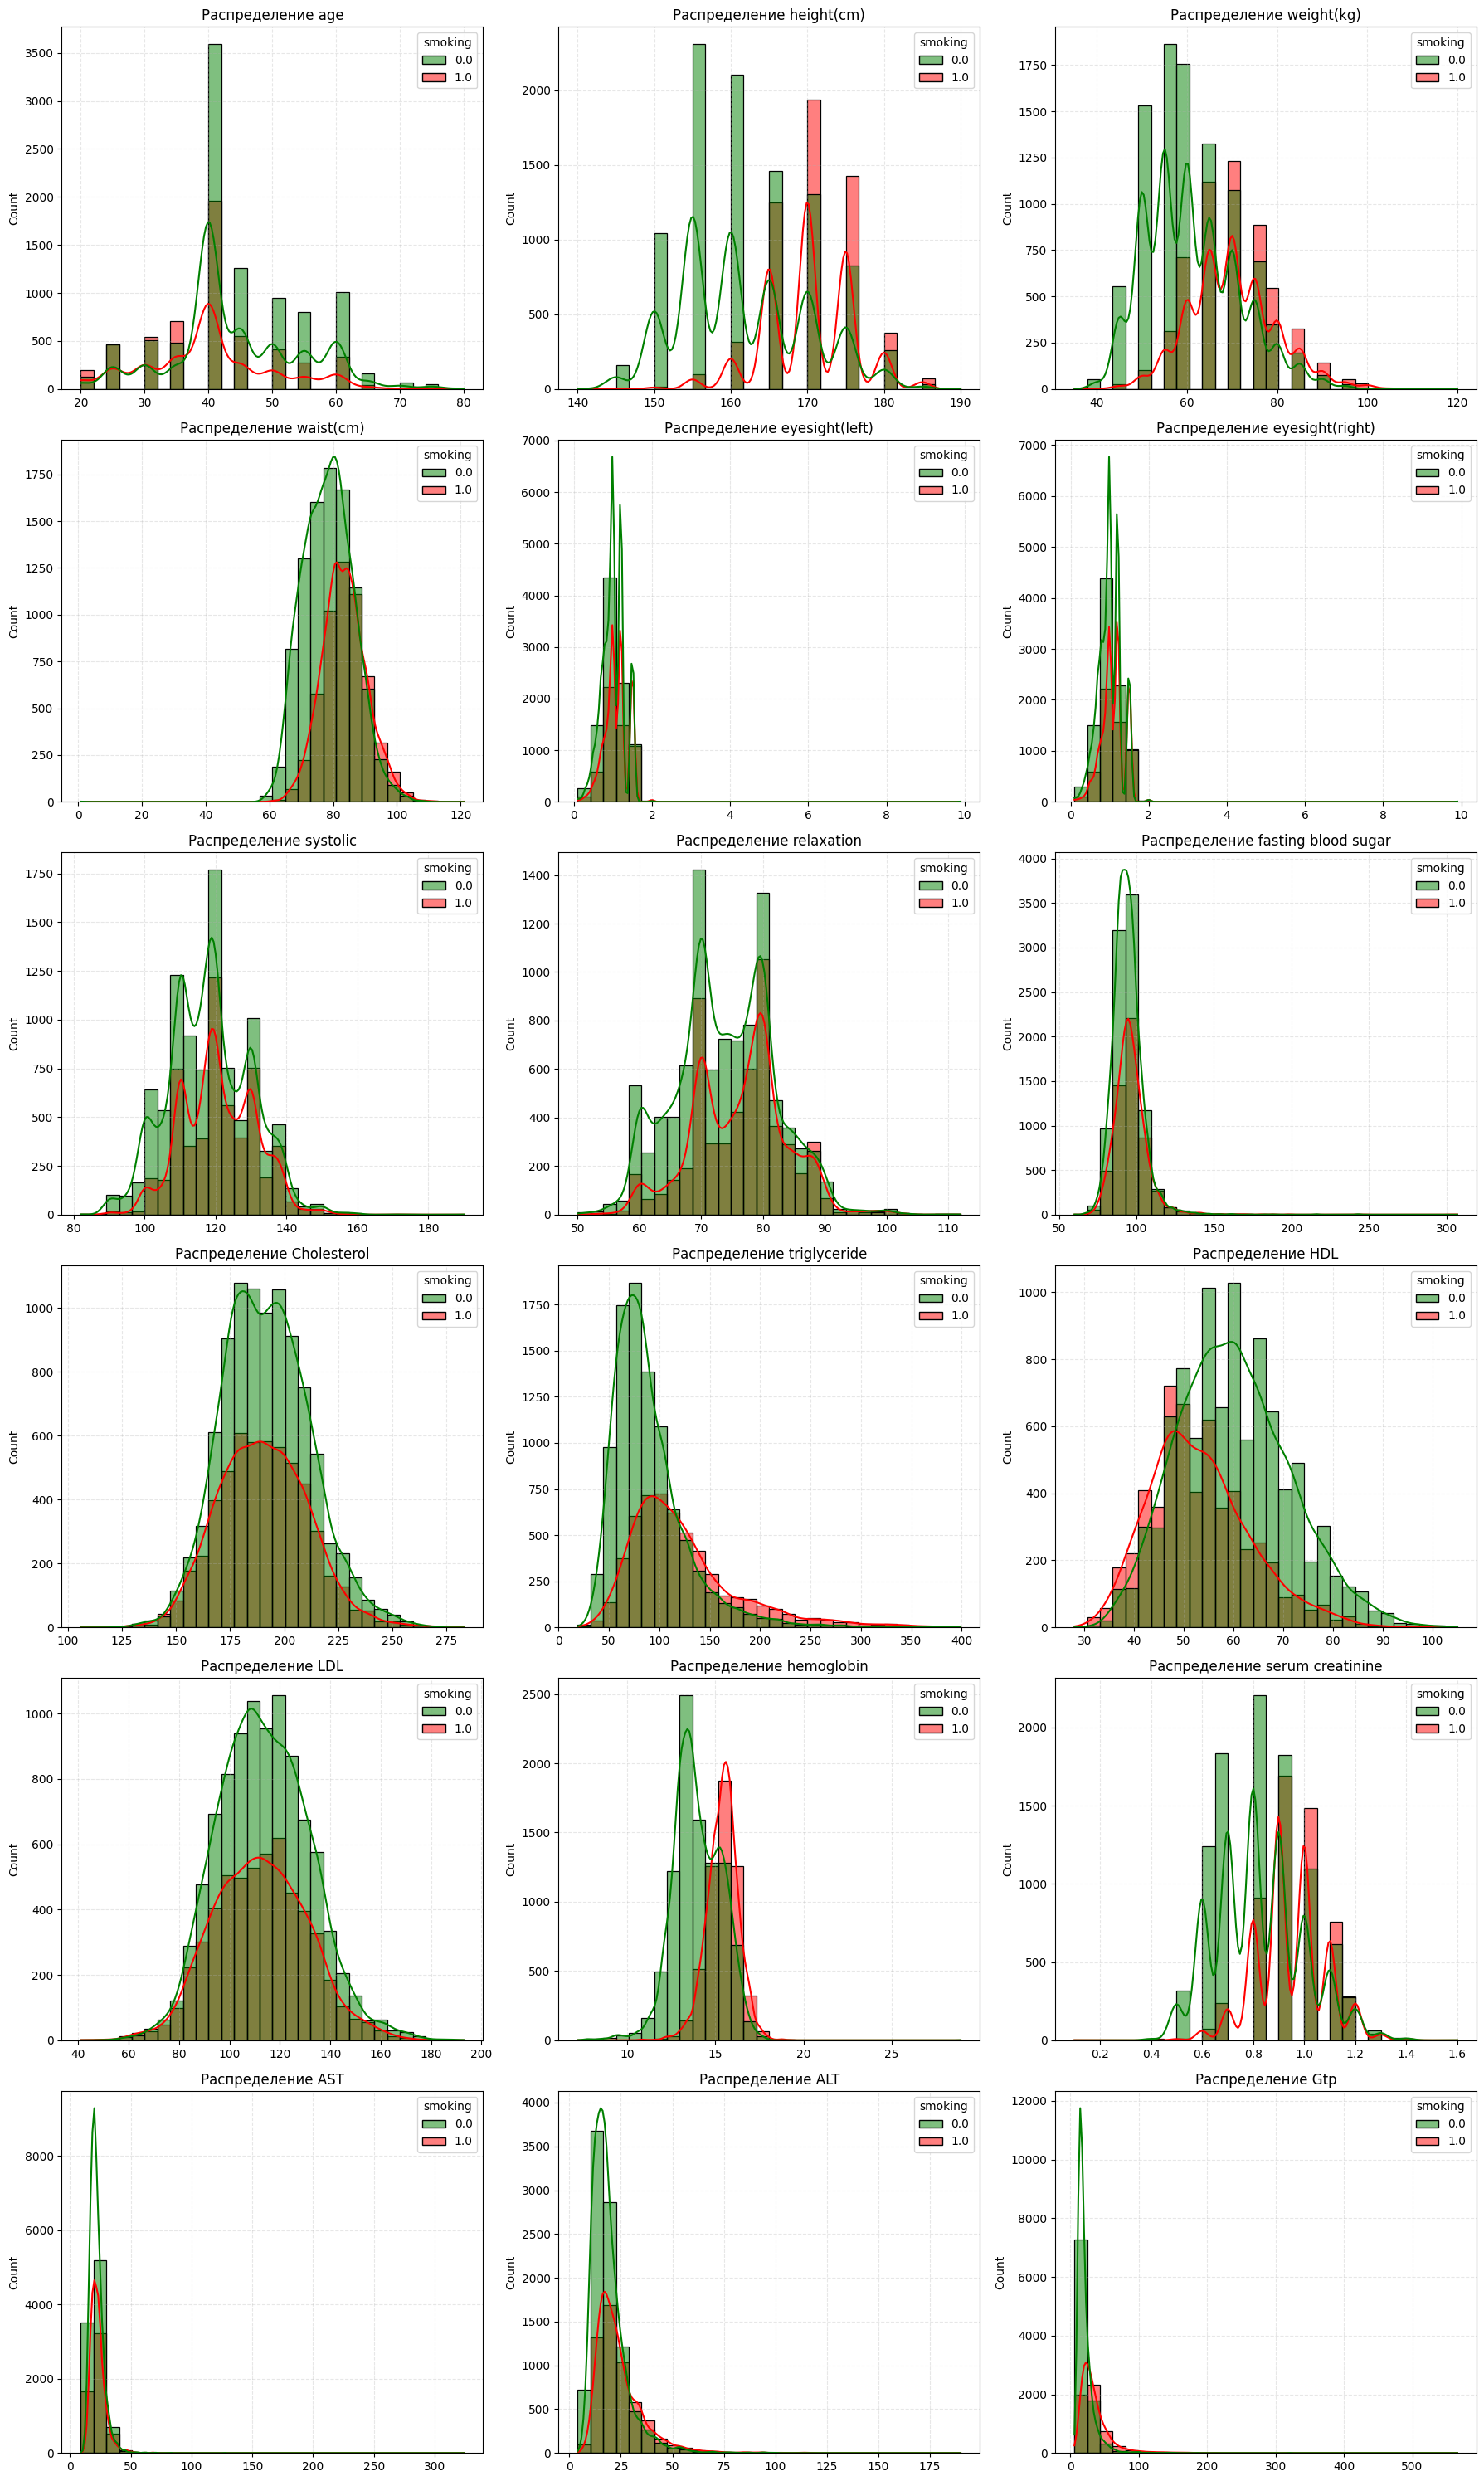

In [118]:
features = [col for col in train_data.drop(columns='smoking').columns if col not in binary_features]

n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))
plt.figure(figsize=(18, 5*n_rows))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)

    sns.histplot(data=train_data, x=feature, hue='smoking',
                 palette={0:'green', 1:'red'},
                 alpha=0.5, kde=True, bins=30)

    plt.title(f'Распределение {feature}')
    plt.xlabel('')
    plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Графики зависимости между признаками

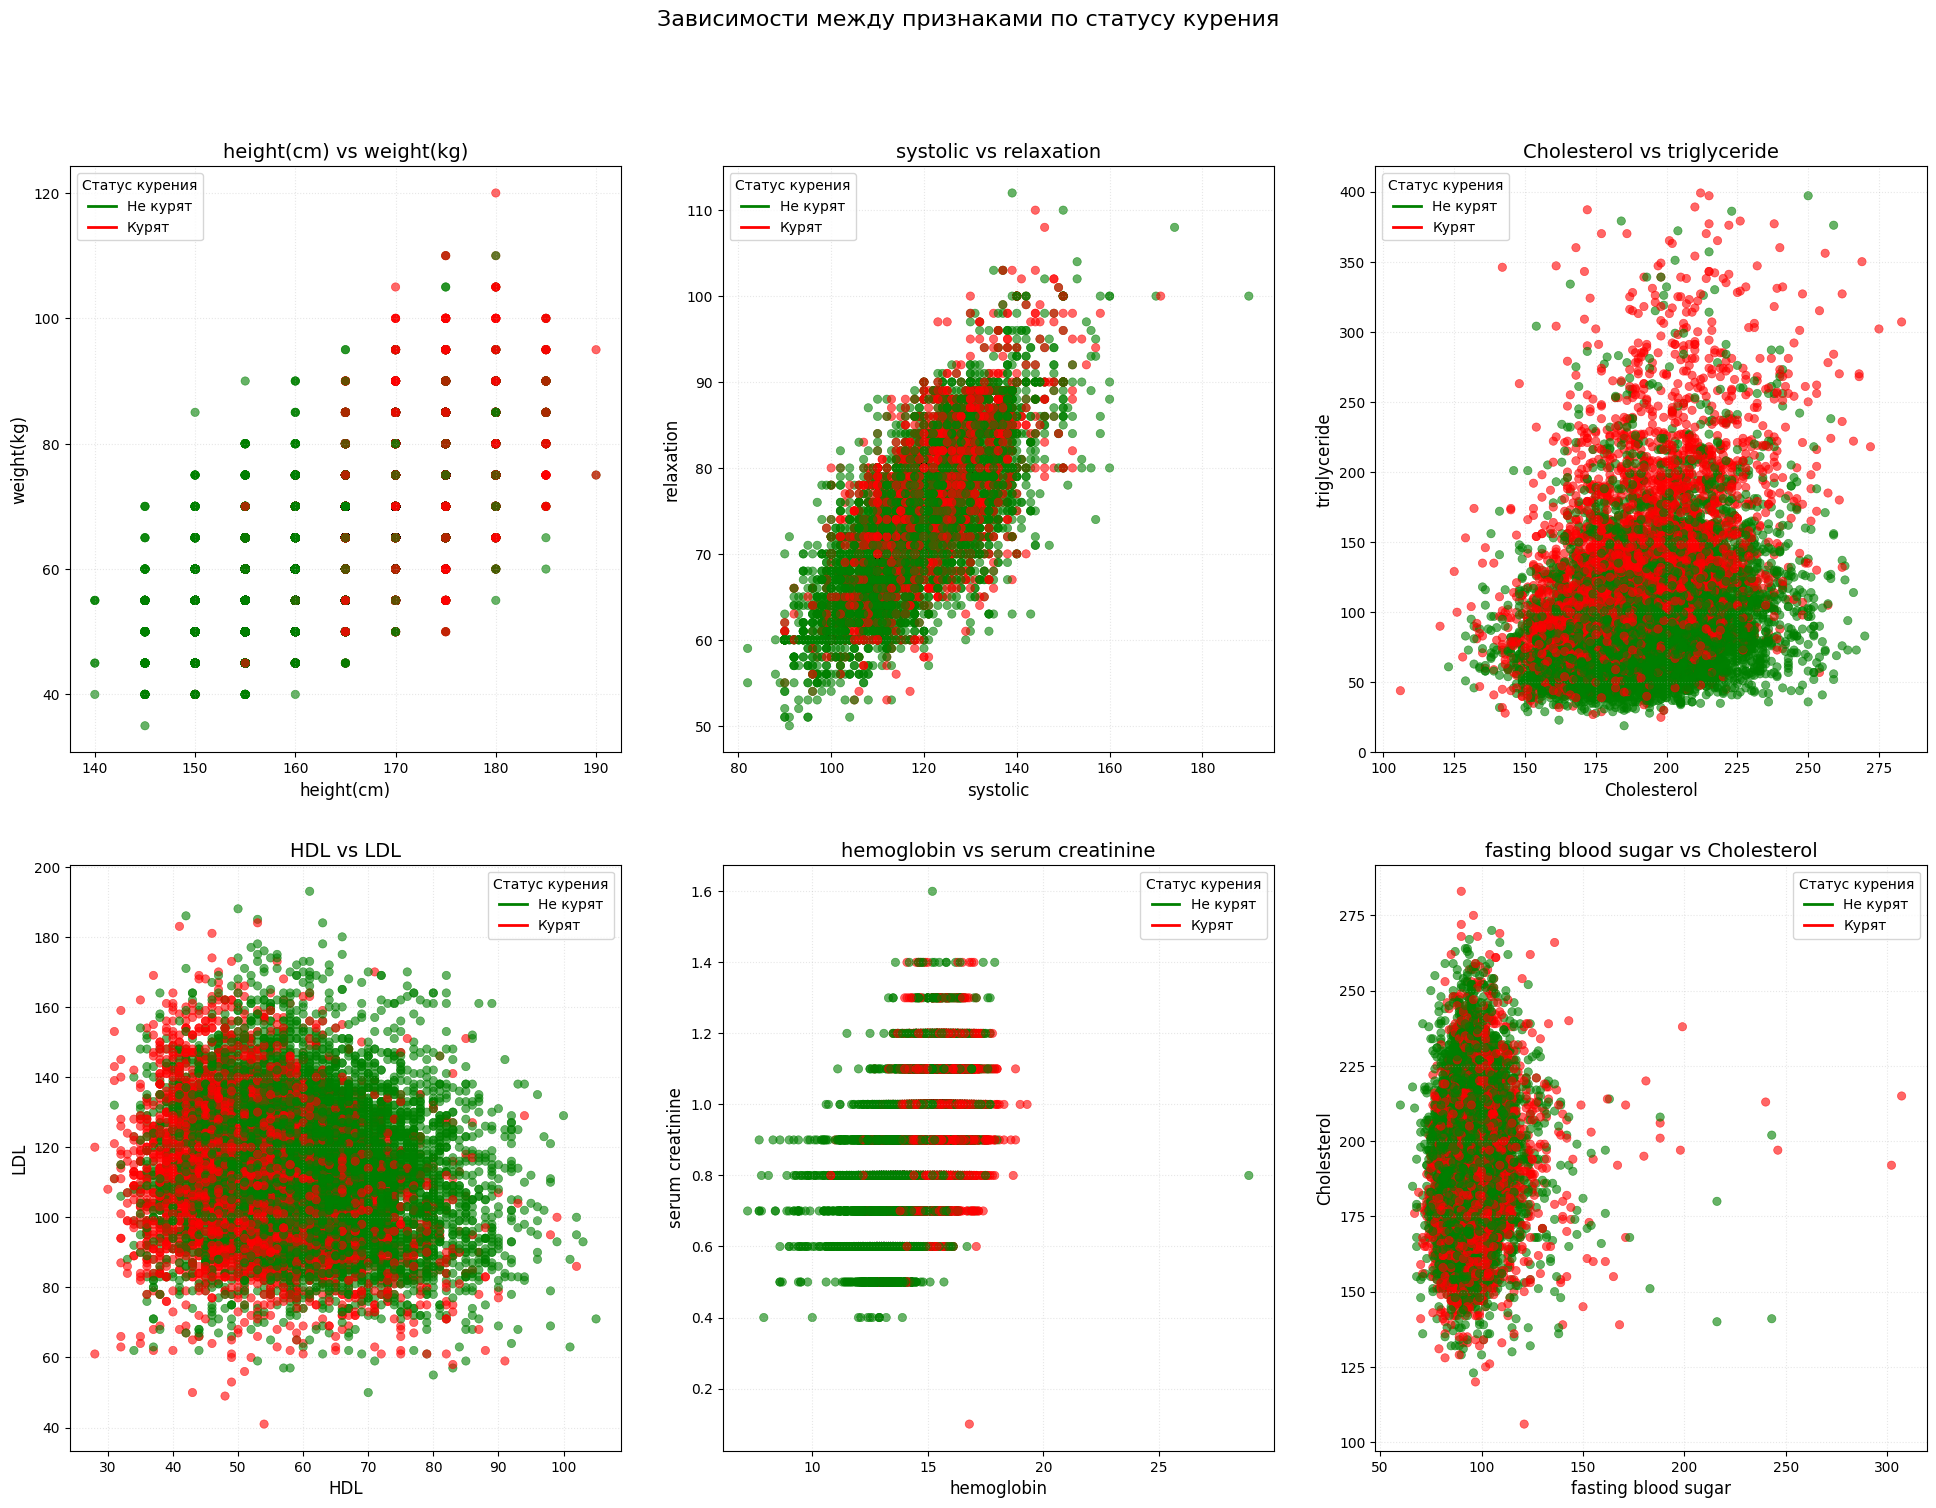

In [119]:
feature_pairs = [
    ('height(cm)', 'weight(kg)'),
    ('systolic', 'relaxation'),
    ('Cholesterol', 'triglyceride'),
    ('HDL', 'LDL'),
    ('hemoglobin', 'serum creatinine'),
    ('fasting blood sugar', 'Cholesterol')
]

plt.figure(figsize=(20, 15))
plt.suptitle('Зависимости между признаками по статусу курения', y=1.02, fontsize=16)

for i, (x_feat, y_feat) in enumerate(feature_pairs, 1):
    plt.subplot(2, 3, i)

    scatter = sns.scatterplot(
        data=train_data,
        x=x_feat,
        y=y_feat,
        hue='smoking',
        palette={0: "green", 1: "red"},
        alpha=0.6,
        edgecolor=None
    )

    plt.title(f'{x_feat} vs {y_feat}', fontsize=14)
    plt.xlabel(x_feat, fontsize=12)
    plt.ylabel(y_feat, fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.3)

    scatter.get_legend().remove()
    plt.legend(title='Статус курения',
              labels=['Не курят', 'Курят'],
              handles=[plt.Line2D([0], [0], color='green', lw=2),
                       plt.Line2D([0], [0], color='red', lw=2)])

plt.tight_layout(pad=3.0)
plt.show()

# Бэггинг

In [120]:
class MyBaggingClassifier:
    def __init__(self, base_model=None, n_models=10, random_state=None):
        self.base_model = base_model if base_model else DecisionTreeClassifier()
        self.n_models = n_models
        self.random_state = random_state
        self.models = []
        np.random.seed(random_state)

    def fit(self, X, y):
        self.models = []
        n_samples = X.shape[0]

        for _ in range(self.n_models):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices]
            y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]

            model = clone(self.base_model)
            model.fit(X_boot, y_boot)
            self.models.append(model)
        return self

    def predict_proba(self, X):
        probas = [model.predict_proba(X) for model in self.models]
        return np.mean(probas, axis=0)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

In [121]:
X = train_data.drop(['smoking'], axis=1)
y = train_data['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data

base_model = DecisionTreeClassifier(max_depth=3, random_state=42)

my_bagging = MyBaggingClassifier(base_model=base_model, n_models=100, random_state=42)
my_bagging.fit(X_train, y_train)
my_proba = my_bagging.predict_proba(X_val)[:, 1]

sklearn_bagging = BaggingClassifier(base_model, n_estimators=100, random_state=42)
sklearn_bagging.fit(X_train, y_train)
sklearn_proba = sklearn_bagging.predict_proba(X_val)[:, 1]

single_tree = clone(base_model)
single_tree.fit(X_train, y_train)
tree_proba = single_tree.predict_proba(X_val)[:, 1]

my_auc = roc_auc_score(y_val, my_proba)
sklearn_auc = roc_auc_score(y_val, sklearn_proba)
tree_auc = roc_auc_score(y_val, tree_proba)

print(f"ROC-AUC scores:")
print(f"- Single Tree: {tree_auc:.6f}")
print(f"- My Bagging: {my_auc:.6f}")
print(f"- Sklearn Bagging: {sklearn_auc:.6f}")

ROC-AUC scores:
- Single Tree: 0.839203
- My Bagging: 0.857006
- Sklearn Bagging: 0.857816


# Бустинг

In [122]:
class MyGradientBoostingClassifier:
    def __init__(self, base_model=None, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.base_model = base_model if base_model else DecisionTreeRegressor(max_depth=max_depth)
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []
        self.initial_pred = None
        np.random.seed(random_state)

    def fit(self, X, y):
        pos_prob = np.mean(y)
        self.initial_pred = np.log(pos_prob / (1 - pos_prob))
        self.train_pred = np.full(len(y), self.initial_pred)

        residuals = y - 1 / (1 + np.exp(-self.train_pred))

        for _ in range(self.n_estimators):
            model = clone(self.base_model)
            model.fit(X, residuals)
            self.models.append(model)

            update = self.learning_rate * model.predict(X)
            self.train_pred += update

            residuals = y - 1 / (1 + np.exp(-self.train_pred))

    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.initial_pred)

        for model in self.models:
            pred += self.learning_rate * model.predict(X)

        proba = 1 / (1 + np.exp(-pred))
        return np.vstack([1-proba, proba]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba > 0.5).astype(int)

In [123]:
my_gb = MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
my_gb.fit(X_train, y_train)
my_proba = my_gb.predict_proba(X_val)[:, 1]

sklearn_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
sklearn_gb.fit(X_train, y_train)
sklearn_proba = sklearn_gb.predict_proba(X_val)[:, 1]

my_auc = roc_auc_score(y_val, my_proba)
sklearn_auc = roc_auc_score(y_val, sklearn_proba)

print("ROC-AUC scores:")
print(f"- My Gradient Boosting: {my_auc:.6f}")
print(f"- Sklearn GBM: {sklearn_auc:.6f}")

ROC-AUC scores:
- My Gradient Boosting: 0.869991
- Sklearn GBM: 0.889797


# Сравнение алгоритмов градиентного бустинга

In [124]:
models = {
    "Sklearn GBM": GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, max_depth=5, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, max_depth=5, force_row_wise=True, verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=100, random_seed=42, max_depth=5, verbose=0)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    results.append({'Model': name, 'ROC-AUC': auc})

results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name} (ROC-AUC = {results_df.iloc[0]['ROC-AUC']:.6f})")

      Model  ROC-AUC
   LightGBM 0.892177
Sklearn GBM 0.890305
   CatBoost 0.887622
    XGBoost 0.882179

Лучшая модель: LightGBM (ROC-AUC = 0.892177)


# Подобор оптимальных гиперпараметров для лучшей модели

In [128]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 27
    }

    model = LGBMClassifier(**params, force_row_wise=True, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=False)

best_params = study.best_params
print("\nЛучшие параметры модели:")
print(pd.DataFrame.from_dict(best_params, orient='index', columns=['Значение']))

final_model = LGBMClassifier(**best_params, force_row_wise=True, verbose=-1)
final_model.fit(X_train, y_train)

y_proba = final_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, y_proba)
print(f"\nROC-AUC после оптимизации: {final_auc:.6f}")


Лучшие параметры модели:
                     Значение
n_estimators       254.000000
max_depth            5.000000
learning_rate        0.050409
num_leaves          65.000000
min_child_samples   22.000000
subsample            0.809693
colsample_bytree     0.896606
reg_alpha            9.482642
reg_lambda           5.403236

ROC-AUC после оптимизации: 0.894893


# Метрики

In [126]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp + 1e-10)

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-10)

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r + 1e-10)

def roc_auc(y_true, y_proba):
    desc_score_indices = np.argsort(y_proba)[::-1]
    y_true_sorted = y_true.iloc[desc_score_indices]

    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)

    tps = [0]
    fps = [0]

    for i in range(len(desc_score_indices)):
        if y_true_sorted.iloc[i] == 1:
            tps.append(tps[-1] + 1)
            fps.append(fps[-1])
        else:
            tps.append(tps[-1])
            fps.append(fps[-1] + 1)

    tps = np.array(tps)
    fps = np.array(fps)

    tpr = tps / n_pos
    fpr = fps / n_neg

    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

    return auc

def pr_auc(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    sort_idx = np.argsort(recall)
    recall = recall[sort_idx]
    precision = precision[sort_idx]

    auc = trapezoid(precision, recall)
    return abs(auc)

In [127]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

metrics = {
    'Accuracy': (accuracy(y_val, y_pred), sk_accuracy(y_val, y_pred)),
    'Precision': (precision(y_val, y_pred), sk_precision(y_val, y_pred)),
    'Recall': (recall(y_val, y_pred), sk_recall(y_val, y_pred)),
    'F1-score': (f1(y_val, y_pred), sk_f1(y_val, y_pred)),
    'ROC-AUC': (roc_auc(y_val, y_proba), sk_roc_auc(y_val, y_proba)),
    'PR-AUC': (pr_auc(y_val, y_proba), sk_pr_auc(y_val, y_proba))
}

results = pd.DataFrame(metrics, index=['My implementation', 'Sklearn'])
print(results.T)

           My implementation   Sklearn
Accuracy            0.801333  0.801333
Precision           0.734888  0.734888
Recall              0.746491  0.746491
F1-score            0.740644  0.740644
ROC-AUC             0.880373  0.880339
PR-AUC              0.769102  0.767512


# Результат

In [129]:
X_train = train_data.drop(columns='smoking')
y_train = train_data['smoking']
X_test = test_data.drop(columns='id')

model = LGBMClassifier(**best_params, force_row_wise=True, verbose=-1)
model.fit(X_train, y_train)
test_proba = model.predict_proba(X_test)[:, 1]

data = np.array([test_data['id'], test_proba]).transpose()
result = pd.DataFrame(data=data, columns=['id', 'smoking'])
result.to_csv('res.csv', index=False)